In [2]:
!pip install torchviz
! pip install split-folders
! pip install torchsummary
! pip install imblearn

In [80]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
from torchsummary import summary
import torch.nn.functional as F
from google.colab import drive
import kagglehub
import os
import shutil
import pickle
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader



In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Download latest version
path = kagglehub.dataset_download("valentynsichkar/cifar10-preprocessed")

print("Path to dataset files:", path)

In [ ]:


# Step 2: Define the paths for the new directories
datasets_folder_path = '/content/drive/My Drive/Datasets'
cifar10_folder_path = os.path.join(datasets_folder_path, 'CIFAR-10')

# Step 3: Create the directories
os.makedirs(cifar10_folder_path, exist_ok=True)

# Step 4: Move the downloaded files to the 'CIFAR-10' folder
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(cifar10_folder_path, filename))

print("Dataset files downloaded to:", cifar10_folder_path)


In [81]:

# Step 1: Load the Pickle File
with open('/content/drive/MyDrive/Datasets/CIFAR-10/data.pickle', 'rb') as f:
    data = pickle.load(f)

# Extract the data
x_train = data['x_train']
y_train = data['y_train']
x_validation = data['x_validation']
y_validation = data['y_validation']
x_test = data['x_test']


In [82]:
# Step 2: Analyze the Data
print("Training data shape:", x_train.shape)  # (49000, 3, 32, 32)
print("Training labels shape:", y_train.shape)  # (49000,)
print("Validation data shape:", x_validation.shape)  # (1000, 3, 32, 32)
print("Validation labels shape:", y_validation.shape)  # (1000,)
print("Test data shape:", x_test.shape)  # (1000, 3, 32, 32)


Training data shape: (49000, 3, 32, 32)
Training labels shape: (49000,)
Validation data shape: (1000, 3, 32, 32)
Validation labels shape: (1000,)
Test data shape: (1000, 3, 32, 32)


In [83]:

# Unique classes in the dataset
unique_classes, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training data:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} samples")


Class distribution in training data:
Class 0: 4913 samples
Class 1: 4881 samples
Class 2: 4921 samples
Class 3: 4888 samples
Class 4: 4922 samples
Class 5: 4902 samples
Class 6: 4898 samples
Class 7: 4893 samples
Class 8: 4887 samples
Class 9: 4895 samples


In [84]:

# Step 3: Visualize the Data
def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Transpose to (H, W, C)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


Training Samples:


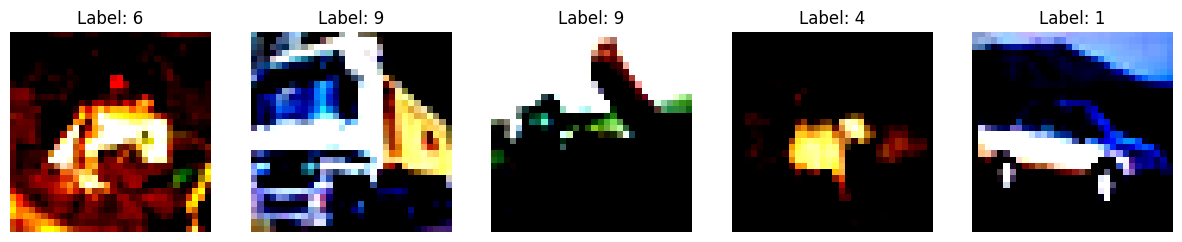

Validation Samples:


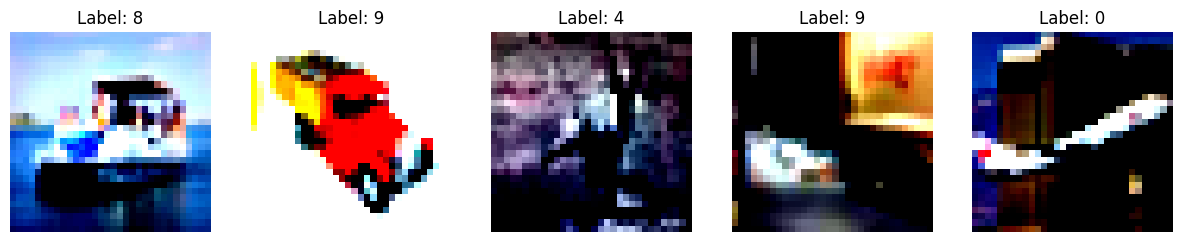

Test Samples:


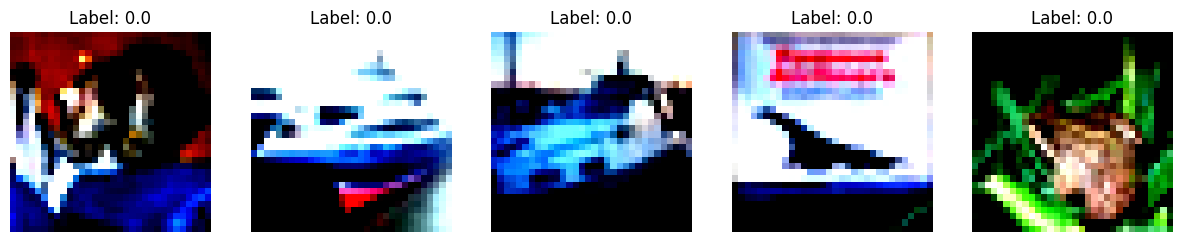

In [85]:

# Visualize samples from the training set
print("Training Samples:")
visualize_samples(x_train, y_train)

# Visualize samples from the validation set
print("Validation Samples:")
visualize_samples(x_validation, y_validation)

# Visualize samples from the test set (no labels available)
print("Test Samples:")
visualize_samples(x_test, np.zeros(x_test.shape[0]))  # Dummy labels

In [86]:
print("Training data shape after transform:", x_train.shape)  # Should be (49000, 3, 32, 32)
print("Validation data shape after transform:", x_validation.shape)  # Should be (1000, 3, 32, 32)
print("Test data shape after transform:", x_test.shape)  # Should be (1000, 3, 32, 32)

Training data shape after transform: (49000, 3, 32, 32)
Validation data shape after transform: (1000, 3, 32, 32)
Test data shape after transform: (1000, 3, 32, 32)


In [87]:
x_train_tensor.shape

torch.Size([49000, 3, 32, 32])

In [88]:
print("Type of x_train:", type(x_train))  # Should be <class 'numpy.ndarray'> or <class 'torch.Tensor'>

Type of x_train: <class 'numpy.ndarray'>


In [127]:

# Step 3: Define Data Augmentation Transforms
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize
])

# Step 4: Apply Transforms to the Data
x_train_augmented = torch.stack([transform_train(img.transpose(1, 2, 0)) for img in x_train])  # Transpose to (height, width, channels)
x_validation_transformed = torch.stack([transform_val_test(img.transpose(1, 2, 0)) for img in x_validation])  # Transpose to (height, width, channels)
x_test_transformed = torch.stack([transform_val_test(img.transpose(1, 2, 0)) for img in x_test])  # Transpose to (height, width, channels)

# Convert to float32
#x_train_augmented = x_train_augmented.float()
x_validation_transformed = x_validation_transformed.float()
x_test_transformed = x_test_transformed.float()

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_validation_tensor = torch.tensor(y_validation, dtype=torch.long)

# Step 5: Create Data Loaders
train_dataset = TensorDataset(x_train_augmented, y_train_tensor)
validation_dataset = TensorDataset(x_validation_transformed, y_validation_tensor)
test_dataset = TensorDataset(x_test_transformed)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=256, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)

print("Data loaders with augmentation created successfully.")

Data loaders with augmentation created successfully.


In [128]:
print("Data type of x_train_augmented:", x_train_augmented.dtype)
print("Data type of x_validation_transformed:", x_validation_transformed.dtype)
print("Data type of x_test_transformed:", x_test_transformed.dtype)

Data type of x_train_augmented: torch.float32
Data type of x_validation_transformed: torch.float32
Data type of x_test_transformed: torch.float32


In [192]:
class EvenMoreComplexCNN(nn.Module):
    def __init__(self):
        super(EvenMoreComplexCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with activation, batch normalization, and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Global Average Pooling
        x = self.global_pool(x)

        # Flatten the output for the fully connected layers
        x = x.view(-1, 512)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)  # Output logits for 10 classes

        return x

In [193]:

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current CUDA device: {current_device}")

    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")


CUDA is available!
Current CUDA device: 0
Number of available GPUs: 1
GPU 0: Tesla T4


In [195]:
# Instantiate the model
model = EvenMoreComplexCNN()


In [196]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the appropriate device
model.to(device)

# Create a dummy input tensor on the same device
input_tensor = torch.randn(1, 3, 32, 32).to(device)

# Print model summary
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 16, 16]          73,856
       BatchNorm2d-4          [-1, 128, 16, 16]             256
            Conv2d-5            [-1, 256, 8, 8]         295,168
       BatchNorm2d-6            [-1, 256, 8, 8]             512
            Conv2d-7            [-1, 512, 4, 4]       1,180,160
       BatchNorm2d-8            [-1, 512, 4, 4]           1,024
            Conv2d-9            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-10            [-1, 512, 2, 2]           1,024
AdaptiveAvgPool2d-11            [-1, 512, 1, 1]               0
           Linear-12                  [-1, 256]         131,328
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [197]:
# Create a dummy input
x = torch.randn(2, 3, 32, 32).to(device)  # Batch size of 1

# Get the output
y = model(x)

# Visualize the model
dot = make_dot(y, params=dict(list(model.named_parameters())))
dot.render("cnn_architecture for cifar10", format="png")  # Save as PNG


'cnn_architecture for cifar10.png'

In [198]:

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=25, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

# Initialize early stopping
early_stopping = EarlyStopping(patience=30, verbose=True)


In [199]:

# Parameters
num_epoch = 200
loss_fn = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#training phase

In [200]:

# Lists to store training statistics
train_loss_list = []
val_loss_list = []
acc_list = []

best_val_loss = float('inf')  # Initialize the best validation loss
best_model_wts = None  # Variable to hold the best model weights


In [ ]:
# Training loop
for epoch in range(num_epoch):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0

    # Training phase
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)  # Average training loss after the loop

    # Validation phase
    model.eval()
    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(validation_loader)  # Average validation loss after the loop

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # Calculate accuracy
    if total > 0:  # Prevent division by zero
        accuracy = 100 * correct / total
    else:
        accuracy = 0.0  # Fallback in case of zero total

    # Store losses and accuracy
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    acc_list.append(accuracy)

    print('-' * 100)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(
        epoch + 1, num_epoch, train_loss, val_loss, accuracy))

    # Check if the current validation loss is the best we've seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        print("Best model weights saved.")

    # Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping at epoch:", epoch + 1)
        break

# Save the best model weights to a file
if best_model_wts is not None:
    torch.save(best_model_wts, 'best_model_weights.pth')
    print("Best model weights saved to 'best_model_weights.pth'.")


----------------------------------------------------------------------------------------------------
Epoch [1/200], Train Loss: 2.1765, Val Loss: 3.5511, Accuracy: 11.40%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [2/200], Train Loss: 1.9429, Val Loss: 3.1473, Accuracy: 9.50%
Best model weights saved.
----------------------------------------------------------------------------------------------------
Epoch [3/200], Train Loss: 1.8374, Val Loss: 3.3150, Accuracy: 8.90%
----------------------------------------------------------------------------------------------------
Epoch [4/200], Train Loss: 1.7460, Val Loss: 3.8749, Accuracy: 9.80%
----------------------------------------------------------------------------------------------------
Epoch [5/200], Train Loss: 1.6634, Val Loss: 7.3460, Accuracy: 8.70%
-------------------------------------------------------------------------------------------------

In [190]:
print(f'Number of epochs: {num_epoch}')
print(f'Train Loss List Length: {len(train_loss_list)}')
print(f'Validation Loss List Length: {len(val_loss_list)}')
print(f'Accuracy List Length: {len(acc_list)}')


Number of epochs: 200
Train Loss List Length: 34
Validation Loss List Length: 34
Accuracy List Length: 34


#visualize model training performance

Number of epochs: 200
Train Loss List Length: 34
Validation Loss List Length: 34
Accuracy List Length: 34


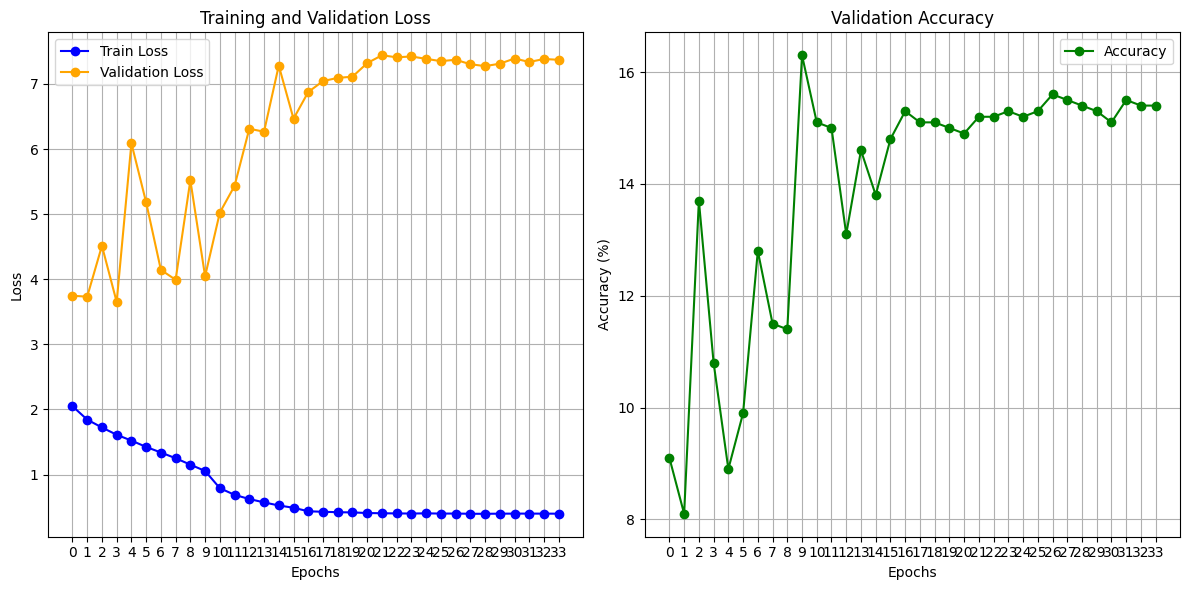

In [191]:
print(f'Number of epochs: {num_epoch}')
print(f'Train Loss List Length: {len(train_loss_list)}')
print(f'Validation Loss List Length: {len(val_loss_list)}')
print(f'Accuracy List Length: {len(acc_list)}')

# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(range(len(train_loss_list)), train_loss_list, label='Train Loss', color='blue', marker='o')
plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation Loss', color='orange', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(train_loss_list)))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Accuracy Plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(range(len(acc_list)), acc_list, label='Accuracy', color='green', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(range(len(acc_list)))  # Ensure all epochs are labeled
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plots
plt.show()